**Install dependencies**

First of all, let's install sepcific version of packages.

In [44]:
!pip install --upgrade scikit-learn==1.3 pandas==1.5.3 numpy==1.22.4

**Importing libraries**

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pylab as plt
import seaborn as sns

**Dataset Overview**

In the experimental, we train, evaluate and analyse a multi-class Gradient Boost Classifier trained on the Palmer's Penguins dataset.

The palmerpenguins data contains size measurements for three penguin species observed on three islands in the Palmer Archipelago, Antarctica.

These data were collected from 2007 - 2009 by Dr. Kristen Gorman with the Palmer Station Long Term Ecological Research Program, part of the US Long Term Ecological Research Network. The data were imported directly from the Environmental Data Initiative (EDI) Data Portal, and are available for use by CC0 license (“No Rights Reserved”) in accordance with the Palmer Station Data Policy.

This dataset is very small (300 examples) and stored as a .csv-like file. Therefore, use Pandas to load it.

In [46]:
dataset_df = pd.read_csv("https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv")
dataset_df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


**Feature engineer**

The dataset contains a mix of numerical (e.g. `bill_depth_mm`), categorical
(e.g. `island`) and Nans. So I convert island to numerical feature and drop Nan rows.

In [47]:
label = "species"
dataset_df = dataset_df.dropna()
classes = dataset_df[label].unique().tolist()
islands = dataset_df['island'].unique().tolist()
sexes = dataset_df['sex'].unique().tolist()
dataset_df[label] = dataset_df[label].map(classes.index)
dataset_df['island'] = dataset_df['island'].map(islands.index)
dataset_df['sex'] = dataset_df['sex'].map(sexes.index)

**Plot classes count**

Display the count of different species of penguis in bar chart, which could help us avoid data skewness.

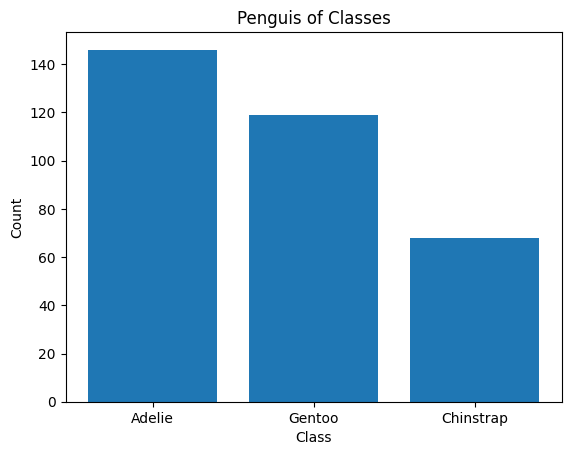

In [48]:
class_counts = dataset_df[label].value_counts()
plt.bar(classes, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Penguis of Classes')
plt.show()

**Plot correlation matrix**

Correlation matrix could help us determine the features we need to reserve when we train the model.

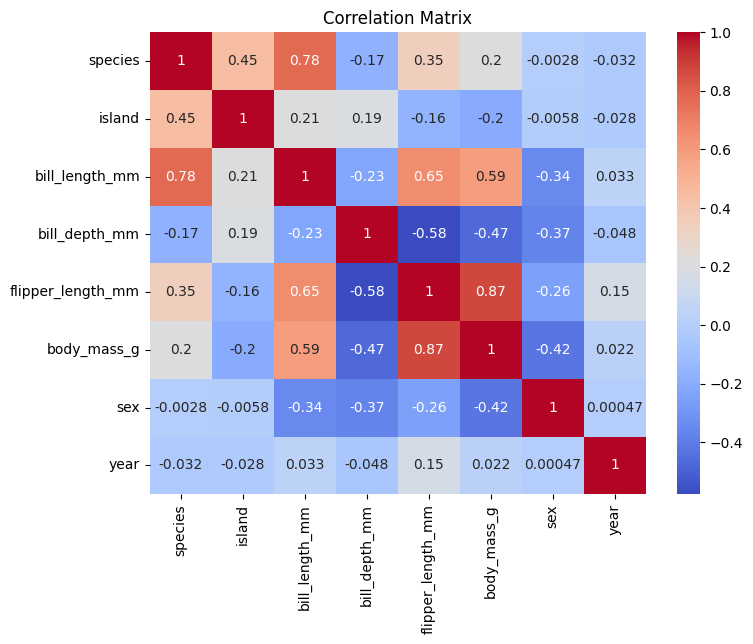

In [50]:
correlation_matrix = dataset_df.corr()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", ax=ax)
ax.set_title("Correlation Matrix")
plt.show()

**Train and Test dataset**

According to correlation matrix, we could drop sex and year feature, since they are not correlated to species and other related features. Although bill_depth_mm also get a negative score in the matrix, but it's highly correlated to other training features, I reserve the feature for training too.  

In [51]:
X = dataset_df.drop(columns=[label, 'sex', 'year'])
y = dataset_df[label]

**Split dataset**

Next split the dataset into training and testing.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

**Train Model**

In the section, I use grid search for auto tune hyper parameters on train dataset.

In [53]:
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [10, 20, 50, 100, 200],
    'ccp_alpha': [0, 0.1, 0.2, 0.25],
    'max_depth': [1, 3, 5],
    'max_leaf_nodes': [2, 10, None]
}
gb = GradientBoostingClassifier(random_state=0, subsample=0.8)
grid = GridSearchCV(gb, params, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(random_state=0,
                                                  subsample=0.8),
             param_grid={'ccp_alpha': [0, 0.1, 0.2, 0.25],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [1, 3, 5],
                         'max_leaf_nodes': [2, 10, None],
                         'n_estimators': [10, 20, 50, 100, 200]})

**Evaluate**

Let's evaluate our model on the test dataset.

In [54]:
print("accuracy:", grid.score(X_test, y_test))
print("Best params:", grid.best_params_)

accuracy: 1.0
Best params: {'ccp_alpha': 0, 'learning_rate': 0.1, 'max_depth': 5, 'max_leaf_nodes': 10, 'n_estimators': 100}


**Plot out-of-bag Losses**

The training logs show the quality of the best model (e.g. accuracy evaluated on the out-of-bag dataset) according to the number of iterations. These logs are helpful to see whether the model is overfit.


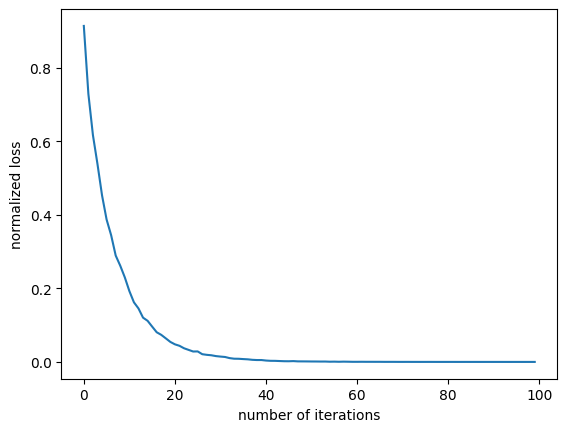

In [55]:
clf = grid.best_estimator_
plt.figure()
plt.plot(range(clf.n_estimators_), clf.oob_scores_)
plt.ylabel("normalized loss")
plt.xlabel("number of iterations")
plt.show()

**Plot Decision Tree**

Plotting the first decision tree and following the first branches helps learning about the best model. In some cases, plotting a model can even be used for debugging.

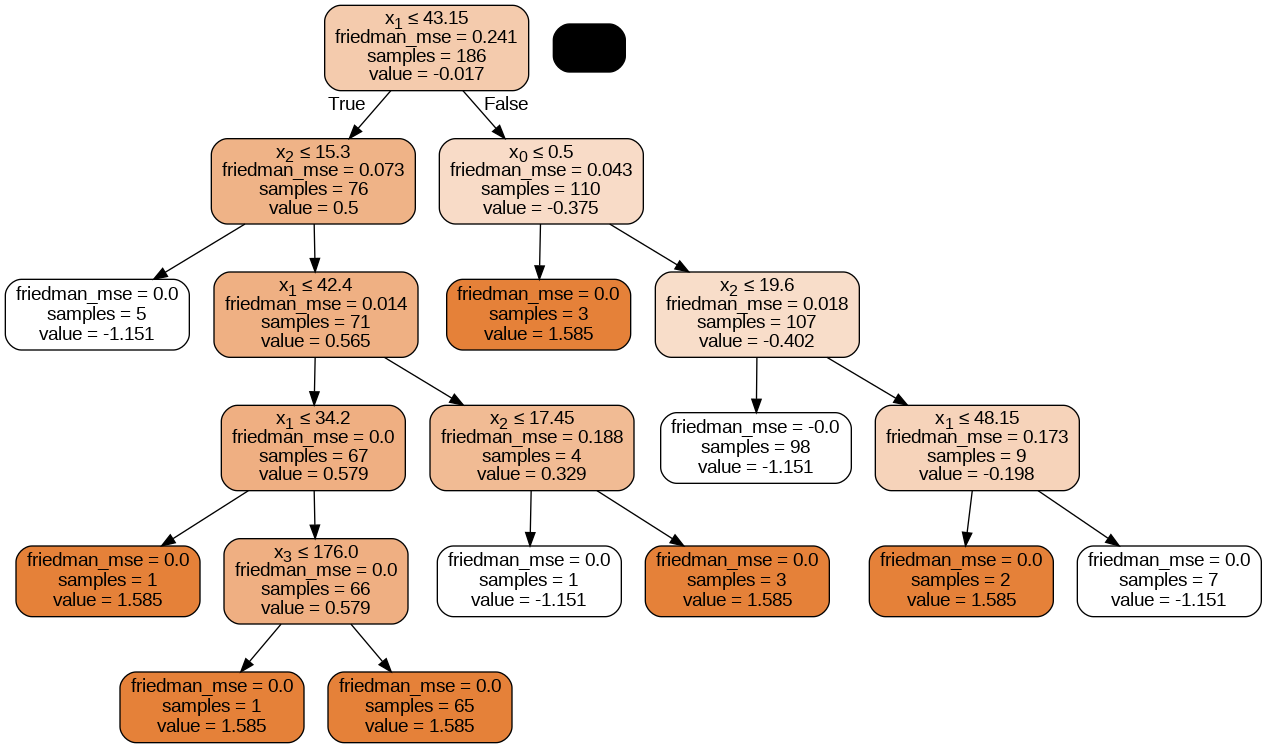

In [56]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

tree = clf.estimators_[0, 0]
dot_data = export_graphviz(
    tree, out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=True
)
graph = graph_from_dot_data(dot_data)
png = graph.create_png()
Image(png)

**Conculsion**

Although I could get SOTA result from the demo, but the training procedure is pretty slow, maybe I could benefit from use some accelerates, such as GPU, IPU or TPU. There is a similar framework called Tensorflow Decision Forest, which has implemented Decision Forests on GPUs and TPUs, could accelerate the training process a lot. I will try it later.